In [1]:
%gui wx
%load_ext autoreload
%autoreload 2
import sys
import os
import os.path as op
import glob

# Import of utils.py functions
current_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(current_dir); sys.path.append(parent_dir); sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

# Loading fsl and freesurfer within Neurodesk
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

# FSL function wrappers which we will call from python directly
loadFSL() # Setup FSL path
from fsl.wrappers import fast, bet, flirt, fslmaths
from fsl.wrappers.misc import fslroi

import mne
import nibabel as nib
import nilearn
import subprocess
import ants
import openneuro

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from preprocessed import viz_fsleyes

In [2]:
dataset_id = 'ds000171'
subject = "sub-control01"
task = 'music'

dataset_path = os.path.join(current_dir, "data", dataset_id)
deriv_path = os.path.join(current_dir,"data", "derivatives")
preproc_path = os.path.join(deriv_path, 'preprocessed_data')
mkdir_no_exist(dataset_path)
mkdir_no_exist(preproc_path)

In [3]:
from preprocessed import viz_fsleyes
viz = True # if false no fsleyesDisplay vizualisations will be displayed
if viz:
    fsleyesDisplay = FSLeyesServer()
    fsleyesDisplay.show()

Gtk-Message: 15:48:56.645: Failed to load module "canberra-gtk-module"

(ipykernel_launcher.py:3097): Gtk-CRITICAL **: 15:48:56.744: gtk_window_resize: assertion 'height > 0' failed


# Anatomical Preprocessing

### Overview of the anatomical 

In [4]:
anatomical_path = op.join(dataset_path, subject, 'anat', '{}_T1w.nii.gz').format(subject)
viz_fsleyes(fsleyesDisplay, [anatomical_path], viz=viz)


(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:48:57.963: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:48:57: Debug: ClientToScreen cannot work when toplevel window is not shown
15:48:57: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:48:57.967: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:48:57: Debug: ClientToScreen cannot work when toplevel window is not shown
15:48:57: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:48:57.970: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:48:57: Debug: ClientToScreen cannot work when toplevel window is not shown
15:48:57: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:48:57.973: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:48:57: Debug: ClientToScreen cannot work when toplevel wi

## Skull removal using bet

In [5]:
from preprocessed import get_skull_stripped_anatomical

resulting_mask = get_skull_stripped_anatomical(dataset_path, preproc_path, subject, robust=True)
viz_fsleyes(fsleyesDisplay, [anatomical_path, resulting_mask], viz=viz)

Done with BET.



(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:49:08.389: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:49:08: Debug: ClientToScreen cannot work when toplevel window is not shown
15:49:08: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:49:08.393: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:49:08: Debug: ClientToScreen cannot work when toplevel window is not shown
15:49:08: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:49:08.395: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:49:08: Debug: ClientToScreen cannot work when toplevel window is not shown
15:49:08: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:49:08.396: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:49:08: Debug: ClientToScreen cannot work when toplevel wi

In [6]:
from preprocessed import apply_fsl_mask

betted_brain_path = apply_fsl_mask(dataset_path, resulting_mask, preproc_path, subject)
viz_fsleyes(fsleyesDisplay, [anatomical_path, betted_brain_path], viz=viz)

Mask applied



(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:49:10.684: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:49:10: Debug: ClientToScreen cannot work when toplevel window is not shown
15:49:10: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:49:10.690: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:49:10: Debug: ClientToScreen cannot work when toplevel window is not shown
15:49:10: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:49:10.691: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:49:10: Debug: ClientToScreen cannot work when toplevel window is not shown
15:49:10: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:49:10.692: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:49:10: Debug: ClientToScreen cannot work when toplevel wi

## Tissue segmentation using fast

In [7]:
from preprocessed import apply_fast

segmentation_path = apply_fast(preproc_path, subject)
pve0 = glob.glob(op.join(preproc_path, subject, 'anat','*pve_0*'))[0]
pve1 = glob.glob(op.join(preproc_path, subject, 'anat','*pve_1*'))[0]
pve2 = glob.glob(op.join(preproc_path, subject, 'anat','*pve_2*'))[0]
viz_fsleyes(fsleyesDisplay, [betted_brain_path, pve0, pve1, pve2], viz=viz)

Done with fast



(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:52:04.380: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:52:04: Debug: ClientToScreen cannot work when toplevel window is not shown
15:52:04: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:52:04.383: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:52:04: Debug: ClientToScreen cannot work when toplevel window is not shown
15:52:04: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:52:04.384: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:52:04: Debug: ClientToScreen cannot work when toplevel window is not shown
15:52:04: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:52:04.385: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:52:04: Debug: ClientToScreen cannot work when toplevel wi

## Linear normalization using Ants

In [8]:
from preprocessed import apply_ants

mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))
t1w_mni = apply_ants(preproc_path, subject, mni_template)
viz_fsleyes(fsleyesDisplay, [mni_template, t1w_mni], viz=viz)


(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:53:10.423: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:53:10: Debug: ClientToScreen cannot work when toplevel window is not shown
15:53:10: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:53:10.426: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:53:10: Debug: ClientToScreen cannot work when toplevel window is not shown
15:53:10: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:53:10.427: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:53:10: Debug: ClientToScreen cannot work when toplevel window is not shown
15:53:10: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:53:10.428: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:53:10: Debug: ClientToScreen cannot work when toplevel wi

##### -> Quality control passed for anatomical preprocessing !

# fMRI Preprocessing

## Field Stabilisation

In [9]:
dataset_path

'/data/data/ds000171'

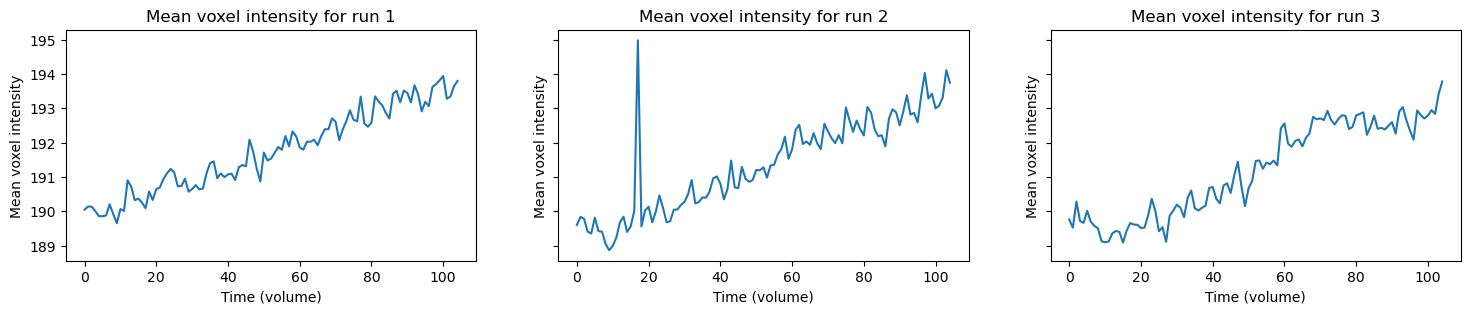

In [10]:
fig,axs = plt.subplots(1,3, sharey = True, figsize= (18,3))
for i in range(3):
    run_i = op.join(dataset_path, subject,'func',f'sub-control01_task-music_run-{i+1}_bold.nii.gz')
    axs[i].plot(nib.load(run_i).get_fdata().mean(axis=(0,1,2)))
    axs[i].set_xlabel('Time (volume)')
    axs[i].set_ylabel('Mean voxel intensity')
    axs[i].set_title(f'Mean voxel intensity for run {i+1}')
plt.show()

Field Stabilisation does not seem necessary

## Standardization and run concatenation

In [11]:
from preprocessed import concatenate_mri_runs

all_runs = concatenate_mri_runs(dataset_path, preproc_path, subject, task, fct= 'zscore')
viz_fsleyes(fsleyesDisplay, [all_runs], viz=viz) # look at volume 122 !!

Concatenation complete. 
Output saved to /data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold.nii.gz



(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:53:25.113: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:53:25: Debug: ClientToScreen cannot work when toplevel window is not shown
15:53:25: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:53:25.115: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:53:25: Debug: ClientToScreen cannot work when toplevel window is not shown
15:53:25: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:53:25.117: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:53:25: Debug: ClientToScreen cannot work when toplevel window is not shown
15:53:25: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:53:25.120: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:53:25: Debug: ClientToScreen cannot work when toplevel wi

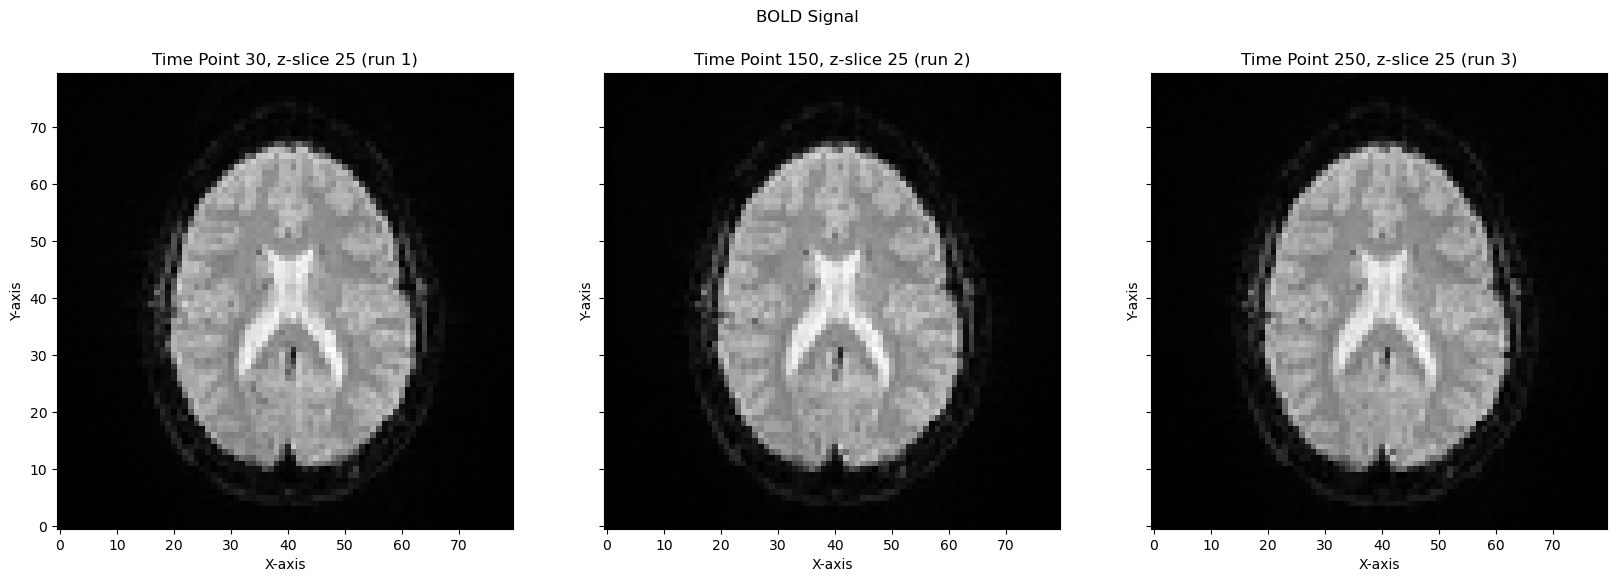

In [12]:
from preprocessed import plot_bold_data, plot_mean_voxel_intensity

plot_bold_data(all_runs, timepoints=[30,150,250])

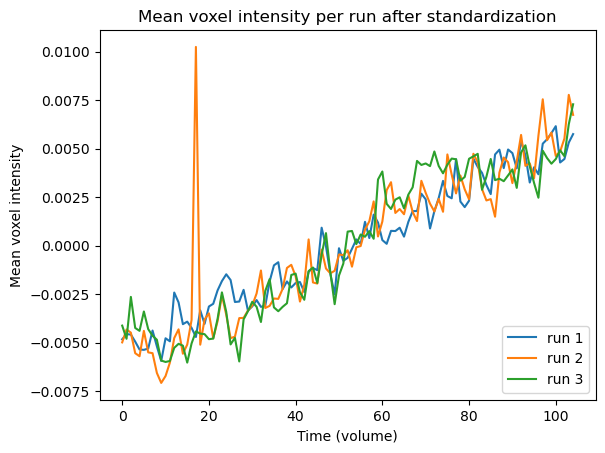

In [13]:
plot_mean_voxel_intensity(all_runs, len_run = 105)

## Motion correction

In [14]:
from preprocessed import apply_mcflirt

run = 'all'
path_moco_data, reference_moco = apply_mcflirt(preproc_path, subject, task, run)
viz_fsleyes(fsleyesDisplay, [path_moco_data, reference_moco], viz=viz) 

Processed data will be saved as /data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [-1] to 8 mm pixels
Registering volumes ... [0][1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19][20][21][22][23][24][25][26][27][28][29][30][31][32][33][34][35][36][37][38][39][40][41][42][43][44][45][46][47][48][49][50][51][52][53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][105][106][107][108][109][110][111][112][113][114][115][116][117][118][119][120][121][122][123][124][125][126][127][128][129][130][131][132][133][134][135][136][137][138][139][140][141][142][143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158

In [15]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_path, subject, 'func', '{}_task-{}_run-{}_bold_moco.par'.format(subject, task, "all")))
display(mot_params)
print('There is basically no frame displacement above 0.2mm (if looking only along X translation)!')

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.003144,0.002962,-0.000150,-0.059815,-0.520661,-0.471032
1,-0.003438,0.002886,-0.000228,-0.064373,-0.496252,-0.468262
2,-0.003195,0.002989,-0.000061,-0.058453,-0.470872,-0.450190
3,-0.003601,0.003242,-0.000338,-0.060681,-0.495291,-0.468538
4,-0.002466,0.003184,-0.000253,-0.078654,-0.464659,-0.493579
...,...,...,...,...,...,...
310,0.009023,-0.000014,-0.002093,-0.087849,0.393414,0.242609
311,0.009136,-0.000229,-0.002163,-0.087794,0.374784,0.221789
312,0.009241,-0.000342,-0.002078,-0.087770,0.406033,0.219116
313,0.009045,-0.000425,-0.002158,-0.104762,0.371790,0.212807


There is basically no frame displacement above 0.2mm (if looking only along X translation)!


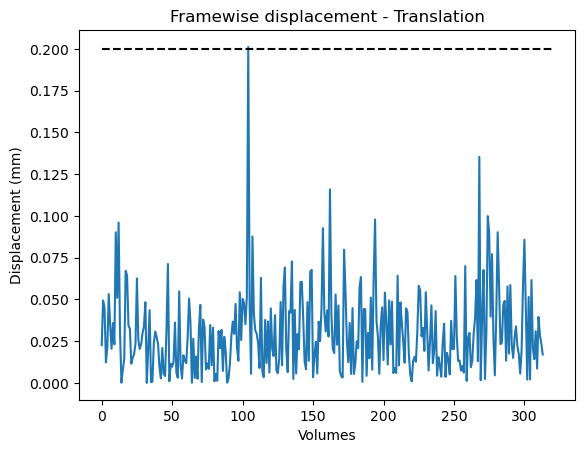

The following frames have a FWD above threshold :  [104]


In [16]:
#compute cumulated absolute translation
trans = np.abs(mot_params["Translation x"]) + np.abs(mot_params["Translation y"]) + np.abs(mot_params["Translation z"])
# Compute distance with respect to previous frame (displacement)
disp = np.diff(trans)
threshold=0.2

plt.plot(abs(disp))
plt.hlines(threshold, 0, 320, colors='black', linestyles='dashed', label='FD threshold')
plt.title("Framewise displacement - Translation")
plt.xlabel("Volumes")
plt.ylabel("Displacement (mm)")
plt.show()
a=np.abs(disp)>threshold
print("The following frames have a FWD above threshold : ", np.where(a)[0])

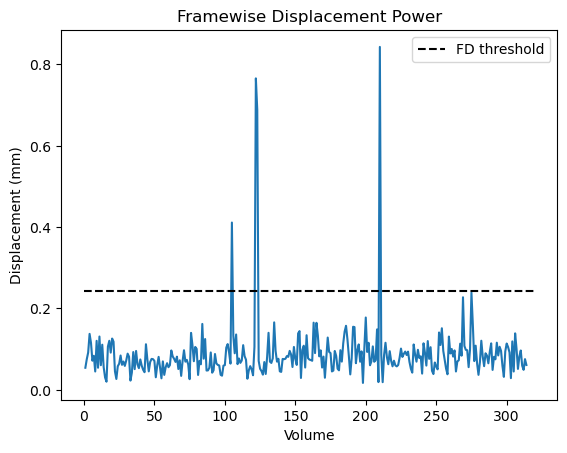

The following frames have a FD power above threshold :  [104 121 122 209]


In [34]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()
threshold = np.mean(fd) + 2 * np.std(fd)

plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('Displacement (mm)')
plt.title("Framewise Displacement Power")
plt.hlines(threshold, 0, 320,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()
a=np.abs(fd)>threshold
print("The following frames have a FD power above threshold : ", np.where(a)[0])

## Epi to anatomical coregistration (not implemented)

This section should not be run as it takes too much time and results in a 30Gb file with all the 3d volumes concatenated after having been coregistered. Due to limited storage space on the VM we decided not to include this in our preprocessing pipeline but given the effort put into it, to leave it here for the corrector to appreciate the effort nonetheless.

In [18]:
from preprocessed import apply_epi_reg
"""
epi_reg_path, reference_epi = apply_epi_reg(dataset_path, preproc_path, path_moco_data, subject, task, 'all')
"""
# We did the coregistration of the reference volume and get a transform, now we need to apply it to all volumes

"\nepi_reg_path, reference_epi = apply_epi_reg(dataset_path, preproc_path, path_moco_data, subject, task, 'all')\n"

In [19]:
# Inspect if the transformation worked
"""
viz_fsleyes(fsleyesDisplay, [betted_brain_path, epi_reg_path], viz=viz)
"""

'\nviz_fsleyes(fsleyesDisplay, [betted_brain_path, epi_reg_path], viz=viz)\n'

In [20]:
#Check how the white matter of the EPI matches the anatomical's white matter
"""
viz_fsleyes(fsleyesDisplay, 
            ['./data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_anat-space_epi_fast_wmseg.nii.gz', './data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_fast_pve_2'], 
            viz=viz)
"""

"\nviz_fsleyes(fsleyesDisplay, \n            ['./data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_anat-space_epi_fast_wmseg.nii.gz', './data/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_fast_pve_2'], \n            viz=viz)\n"

In [21]:
# We split the volumes to later apply epi_reg one by one
"""
path_epi_transform = op.join(preproc_path, subject, 'func/sub-control01_task-music_run-all_bold_anat-space_epi.mat')
split_target = path_moco_data
splits_path = op.join(preproc_path, subject, 'func','splits') # or place it in Desktop for more space
mkdir_no_exist(splits_path)
split_name = op.join(splits_path, 'sub-control01_task-music_run-all_bold_split')

subprocess.run(['fslsplit', split_target, split_name, '-t'])

split_vols = sorted(glob.glob(op.join(splits_path, '*_bold_*')))
viz_fsleyes(fsleyesDisplay, [split_vols[0], split_vols[120], split_vols[220]], viz=viz)
"""

"\npath_epi_transform = op.join(preproc_path, subject, 'func/sub-control01_task-music_run-all_bold_anat-space_epi.mat')\nsplit_target = path_moco_data\nsplits_path = op.join(preproc_path, subject, 'func','splits') # or place it in Desktop for more space\nmkdir_no_exist(splits_path)\nsplit_name = op.join(splits_path, 'sub-control01_task-music_run-all_bold_split')\n\nsubprocess.run(['fslsplit', split_target, split_name, '-t'])\n\nsplit_vols = sorted(glob.glob(op.join(splits_path, '*_bold_*')))\nviz_fsleyes(fsleyesDisplay, [split_vols[0], split_vols[120], split_vols[220]], viz=viz)\n"

#### Apply the trasnformation to each volume independently 

In [22]:
"""
splits_epi_path = op.join(preproc_path, subject, 'func','splits_epi')
mkdir_no_exist(splits_epi_path)

start = 0

for i, split_vol in tqdm(enumerate(split_vols[start:]), initial = start, total = 315): 
    split_nbr = split_vol.split('_')[-1].split('.')[0].split('split')[1]
    out_vol = op.join(splits_epi_path,'sub-control01_task-music_run-all_bold_epi_vol' + split_nbr) # or output to desktop
    
    subprocess.run(['flirt', '-in', split_vol, '-ref', anatomical_path,'-out', out_vol,
                        '-init', path_epi_transform,'-applyxfm'])
os.system('rm -rf {}'.format(op.join(splits_path, '*_bold_split*'))) # remove the splits from disk
"""

"\nsplits_epi_path = op.join(preproc_path, subject, 'func','splits_epi')\nmkdir_no_exist(splits_epi_path)\n\nstart = 0\n\nfor i, split_vol in tqdm(enumerate(split_vols[start:]), initial = start, total = 315): \n    split_nbr = split_vol.split('_')[-1].split('.')[0].split('split')[1]\n    out_vol = op.join(splits_epi_path,'sub-control01_task-music_run-all_bold_epi_vol' + split_nbr) # or output to desktop\n    \n    subprocess.run(['flirt', '-in', split_vol, '-ref', anatomical_path,'-out', out_vol,\n                        '-init', path_epi_transform,'-applyxfm'])\nos.system('rm -rf {}'.format(op.join(splits_path, '*_bold_split*'))) # remove the splits from disk\n"

#### Combining runs together

In [23]:
from preprocessed import combine_splits
"""
epi_all = combine_splits(preproc_path, splits_epi_path, subject)
#Compare against anatomical path
viz_fsleyes(fsleyesDisplay, [anatomical_path, epi_all], viz=viz)
"""

'\nepi_all = combine_splits(preproc_path, splits_epi_path, subject)\n#Compare against anatomical path\nviz_fsleyes(fsleyesDisplay, [anatomical_path, epi_all], viz=viz)\n'

## Slice Time correction

In [24]:
data = pd.read_json(op.join(dataset_path, 'task-{}_bold.json'.format(task)), typ= 'series')
slice_timing = data['SliceTiming']
tr = data['RepetitionTime'] 

In [25]:
# Get header information - to determine the number of slices
#print(os.system('fslhd {}'.format(op.join(preproc_path, subject, 'func', 'sub-control01_task-music_run-all_bold_moco.nii.gz'))))
#print('The dimension on which the slides are should have length ~', len(slice_timing)) 
# ----> Dimension of the slices here is the z dimension so we give dim  = 3 to slicetimer below 

In [26]:
from preprocessed import apply_slice_timer

file_to_realign = op.join(preproc_path, subject, 'func', 'sub-control01_task-music_run-all_bold_moco.nii.gz')
slice_corrected = apply_slice_timer(preproc_path, subject, task, run, file_to_realign, slice_timing, tr, dim=3)
viz_fsleyes(fsleyesDisplay, [slice_corrected], viz=viz)


(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:56:36.561: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:56:36: Debug: ClientToScreen cannot work when toplevel window is not shown
15:56:36: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:56:36.564: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:56:36: Debug: ClientToScreen cannot work when toplevel window is not shown
15:56:36: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:56:36.565: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:56:36: Debug: ClientToScreen cannot work when toplevel window is not shown
15:56:36: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:56:36.566: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:56:36: Debug: ClientToScreen cannot work when toplevel wi

## Smoothing

In [27]:
mkdir_no_exist(op.join(preproc_path, subject, 'func', 'final'))
smooth_voxel = 9 #mm
output_path = op.join(preproc_path, subject, 'func', 'final', f'sub-control01_task-music_run-all_bold_smoothed-{smooth_voxel}mm')

subprocess.run(['fslmaths', slice_corrected, '-s', str(smooth_voxel/2.3548), output_path])

CompletedProcess(args=['fslmaths', '/data/data/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-all_bold_slice-corr', '-s', '3.8219806352981145', '/data/data/derivatives/preprocessed_data/sub-control01/func/final/sub-control01_task-music_run-all_bold_smoothed-9mm'], returncode=0)

In [28]:
viz_fsleyes(fsleyesDisplay, [output_path], viz=viz)


(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:57:31.552: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:57:31: Debug: ClientToScreen cannot work when toplevel window is not shown
15:57:31: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:57:31.554: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:57:31: Debug: ClientToScreen cannot work when toplevel window is not shown
15:57:31: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:57:31.555: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:57:31: Debug: ClientToScreen cannot work when toplevel window is not shown
15:57:31: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:3097): Gdk-WARNING **: 15:57:31.557: gdkdrawable-x11.c:952 drawable is not a pixmap or window
15:57:31: Debug: ClientToScreen cannot work when toplevel wi